# Building an Ocean model

The objective: understand the basics behind a simple particle tracking simulation using Oceananigans.jl

## What is Oceananigans.jl?

***Oceananigans.jl*** is an ocean modeling library built in the Julia programming language. <br>
Oceananigans is designed to be user-friendly and flexible and is capable of performing all types of <br>
simulations, from _small-scale_ "isotropic" simulations to _large-scale_ realistic oceans! <br>

In this lab, you will learn the syntax of Oceananigans.jl and bits of ***Julia*** (data structures, load data, plotting) <br>
mainly in the context of the Oceananigans package, as we go along. You will learn how to set <br>
up and run a simple simulation with Oceananigans.

We will go through all the Oceananigans' building blocks (if time allows it!):
1) Grids (this module)<br>
2) Fields (this module)<br>
3) Models (module 2)<br>
4) Simulation (module 2)<br>

If you are interested in learning more about Julia and Oceananigans get in touch on the #julia-helpdesk slack channel

# Part 1: Install a package, load and visualize data

## Packages in julia

Like Python, also Julia relies on a package system. <br>

Julia provides an in-build package manager to simplify adding and loading packages. <br>
For example, to install the package "Downloads" (https://github.com/JuliaLang/Downloads.jl) it is sufficient to run `Pkg.add("Downloads")`. <br>
Once installed, we can use the package through `using Downloads`

In [1]:
using Pkg
Pkg.add("Downloads")
using Downloads

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Oceananigans is already installed on the hub, so it is not 
necessary to `Pkg.add("Oceananigans")`. 

We can use Oceananigans with

In [2]:
Pkg.add(name="Oceananigans", rev="ss/default_nan_checker")
using Oceananigans

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


### First step: define the domain

The ocean exists in a complex domain: it has a variable seabed height and is bounded by continents and islands. <br> 
All this information is visualized through a _bathymetry_ map. <br>
The term "bathymetry" refers to the ocean's depth relative to sea level. <br>
In the same way, a _topographic_ map describes the elevation of the terrain, a _bathymetric_ map illustrates the land that lies underwater. 

The bathymetry will define the domain in which we set up the ocean model. <br>

A dataset containing the bathymetric information can be in ../shared/bathymetry.jld2


#### JLD2 filetype

Note that the file has the `*.jld2` extension. <br>
This is a Julia filetype (same as `*.hdf5` in python) which can be opened using the `JLD2` package

In [3]:
using JLD2
file_bathymetry = jldopen("./bathymetry.jld2")

JLDFile /Users/simonesilvestri/development/JuliaComputationLecture2023/bathymetry.jld2 (read-only)
 └─🔢 bathymetry

A _JLDFile_ is a `Dictionary`, a collection of datasets that can be accessed using _strings_ as keys <br>
(akin to how Dictionaries work in python). <br>
The bathymetry can be accessed with the "bathymetry" key.

In [4]:
bathymetry = file_bathymetry["bathymetry"]

# Let's look at the type and size of the variable _bathymetry_
@show size(bathymetry)
@show typeof(bathymetry)

size(bathymetry) = (1440, 600)
typeof(bathymetry) = Matrix{Float64}


Matrix{Float64} (alias for Array{Float64, 2})

The bathymetric map is a `Matrix` (an alias for a two-dimensional array `Array`) <br>
of size 1440x600. You can think of these numbers as the _resolution_ (number of pixel) of the map. <br>

### Plotting 2D data

Let us plot the bathymetry and visualize underwater elevation <br>
Plotting in Julia can be done through the package `CairoMakie` <br>

The steps for plotting in CairoMakie are:
- define a figure as `fig = Figure()`. A resolution can be specified. It is possible to index the figure as a matrix
- specify an axis in the figure `ax = Axis(fig[1, 1])` (1, 1 stands for position 1, 1 in the figure layout)
- plot something inside the axis (using `ax` as an argument)

Since we will work with simulations of the ocean surface (two-dimensional), <br>
we can use the `heatmap!` function, which plots matrices (`contour!` could have been another choice). <br>
In a heatmap, the `colorrange` keyword specifies the contour limits. <br>
The colormap is chosen with the `colormap` keyword (choice of different colormaps, :balance, :hot, :viridis, :plasma, etc...)

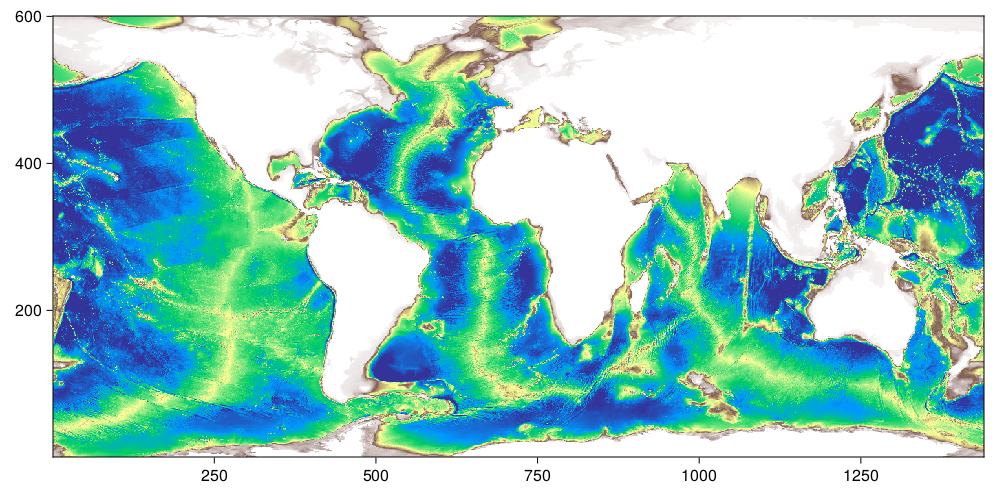

In [8]:
using CairoMakie

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])

heatmap!(ax, bathymetry, colorrange = (-5500, 100), colormap = :terrain)

current_figure()

# Part 2: build a computational Grid

The fluid in the ocean is _continuous_, but a computer can only operate on _discrete_ quantities (vectors, arrays, matrices). <br>
To _represent_ a continuous fluid on a computer, we need to _discretize_ our geometry into "computational cells".
The entirety of all the computational cells and their arrangement form a ***grid*** (or a ***mesh***).

Grids are the backbone of ***all*** fluid flow simulations: constructing an adequate grid goes a long way in ensuring a good quality model.

Oceananigans allows to construct two types of grids: 
- a `RectilinearGrid` for problems defined in a rectangular space
- a `LatitudeLongitudeGrid` for problems defined on a sphere

If we want to discretize the ocean, we need a sphere! <br>

Let us choose the number of points in the latitude and longitude direction (`Nlat` and `Nlon`) and construct our grid <br>
We will simulate the transport over the ocean surface, so we do not need a "vertical" direction. <br>
The size of the grid will, hence, be `(Nlat, Nlon, 1)`

In [18]:
Nlon = 1440
Nlat = 600

initial_grid = LatitudeLongitudeGrid(size = (Nlon, Nlat, 1), longitude = (-180, 180), latitude = (-75, 75), z = (0, 1))

1440×600×1 LatitudeLongitudeGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo and with precomputed metrics
├── longitude: Periodic λ ∈ [-180.0, 180.0) regularly spaced with Δλ=0.25
├── latitude:  Bounded  φ ∈ [-75.0, 75.0]   regularly spaced with Δφ=0.25
└── z:         Bounded  z ∈ [0.0, 1.0]      regularly spaced with Δz=1.0

Take a second to look at the pieces of information contained in this grid <br>
(spacing and limits for each direction which can be periodic or bounded) <br>

At the moment, this grid is just a spherical shell. <br>
To convert it into a realistic representation of the ocean, we have to load in the bathymetric map <br>

some convenience functions to interpolate our domain (the bathymetric map) onto the grid <br> are implemented in the file "useful_functions.jl" (within the folder "utils")

In Julia we can load source files `(*.jl)` through the function `include`. <br>
Including a source file will load all the functions defined in it.<br>
(you are welcome to look at the functions defined in "utils/useful_functions.jl")

In [19]:
include("utils/useful_functions.jl")
grid = immersed_boundary_grid(initial_grid, bathymetry);

You can use the `visualize_cartesian_grid` function (defined in "useful_functions.jl") to plot the grid. <br> 
It uses the `CairoMakie` package to visualize a wireframe of the computational cells and a 
heatmap of the discrete continental mask.

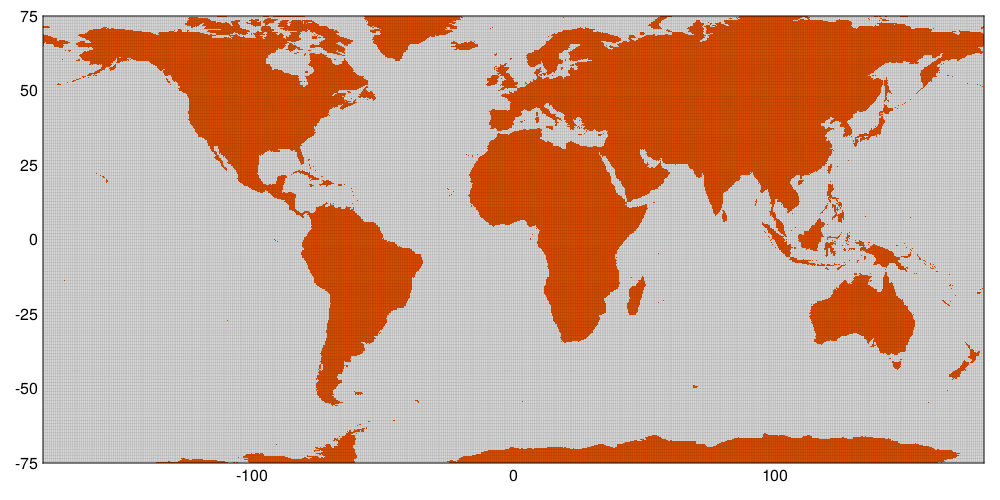

In [20]:
fig = visualize_cartesian_grid(grid)
current_figure()

Think about the cells in a grid as the "pixels" of an image; A larger number of pixels allow us to see more detailed images. <br>
The same happens in an ocean simulation; a larger number of cells (pixels) in a grid, <br>
allows us to "resolve" more detailed physics.

## Exercise: change the grid resolution

try changing the number of points in the longitudinal (`Nlat`) and the latitudinal (`Nlon`) direction, <br>
and see how the representation of the continents changes.

It is also possible to change the latitude and longitude of the domain to "zoom in" in particular regions <br>
For example, try `latitude = (-35, 30)` and `latitude = (-30, 30)` to zoom into west africa's coast

#### Note!
the bathymetry data has a size of (1440 x 600), so the maximum resolution allowable is `Nx = 1440`, `Ny = 600`

In [ ]:
## Write the new grid here
## look at the examples above:

# - define Nlon and Nlat
# - build an initial_grid (choose latitude = (ᵒwest, ᵒeast), longitude = (ᵒsouth, ᵒnorth))
# - build the grid with the immersed_boundary_grid function
# - visualize with the visualize_figure function
# - display the figure with current_figure()

# Part 3: download and interact with a velocity field

### Load velocity datasets

To load the (precomputed) velocity datasets, we again use the `JLD2` package.

In [21]:
file_velocities = jldopen("./prescribed_mean_fields.jld2")

JLDFile /Users/simonesilvestri/development/JuliaComputationLecture2023/prescribed_mean_fields.jld2 (read-only)
 ├─🔢 um
 └─🔢 vm

This file is a Dictionary containing two datasets:
- um
- vm 

Here `um` is the _zonal_ surface velocity (the surface velocity in the West-East direction) <br>
and `vm` is the _meridional_ surface velocity (the surface velocity in the South-North direction, along meridians). <br>
 
These datasets contain the velocities ***averaged*** over a period of 10 years. <br>
Let us assign these datasets to two variables and look at their structure.

In [22]:
const Um = file_velocities["um"]
const Vm = file_velocities["vm"]

1440×601×1 Array{Float64, 3}:
[:, :, 1] =
 0.0   0.0175359    0.034818    …  -0.00271444    0.00377162   0.0
 0.0  -0.0297351   -0.0889434       0.00213779    0.0024355    0.0
 0.0  -0.0279604   -0.0511151      -0.00378649   -0.0029095    0.0
 0.0   0.00860245   0.00975922     -0.00154688   -0.00062936   0.0
 0.0   0.0191674    0.0319965      -0.00624658    0.00655592   0.0
 0.0  -0.0114655    0.0202195   …  -0.00971378    0.00747828   0.0
 0.0  -0.0133509   -0.0052568      -0.00256348    0.00197651   0.0
 0.0  -0.0328653   -0.011537       -0.00266049    0.00304964   0.0
 0.0  -0.0177057   -0.0388232      -0.000797686  -0.00036531   0.0
 0.0   0.018297     0.00839795      0.00362976   -0.00923893   0.0
 ⋮                              ⋱                              ⋮
 0.0   0.00247171  -0.0253447      -0.00300193   -0.0024151    0.0
 0.0   0.00278313  -0.0222039      -0.000631595   0.00121136   0.0
 0.0  -0.00025989   0.00398255     -0.01066       0.0035863    0.0
 0.0   0.028913     0.

In [23]:
typeof(Um)

Array{Float64, 3}

In [24]:
typeof(Vm)

Array{Float64, 3}

Note that both the Arrays (`Um` and `Vm`) are ***3D*** arrays! Oceananigans handles always three-dimensional data for simplicity, <br>
a two-dimensional dataset (as in this case) is represented by a 3D array with ***one*** point in the unused direction

Let us plot the zonal velocity with `CairoMakie`. <br>
Since `Um` is a 3D array, we can plot it as `Um[:, :, 1]` (heatmap plots only 2D arrays)

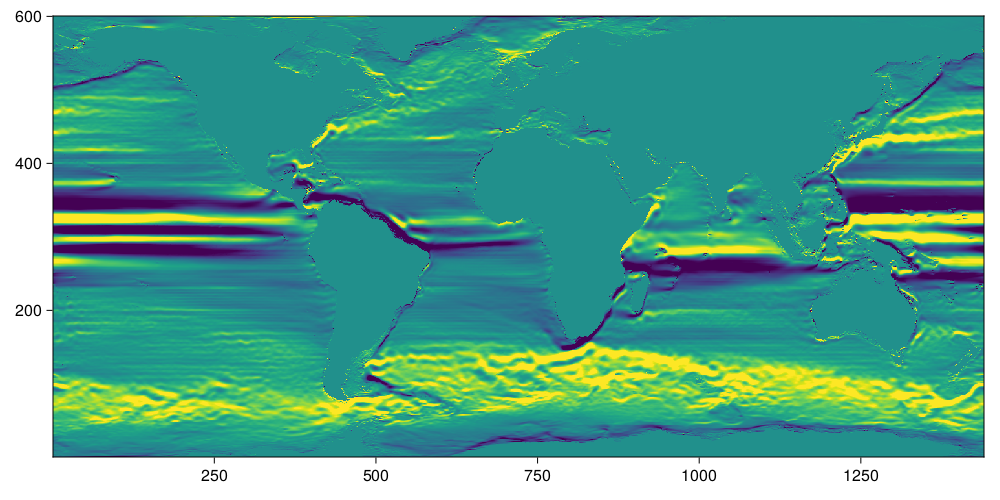

In [25]:
# Mean zonal velocity
u = Um[:, :, 1]

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, u, colorrange = (-0.2, 0.2), colormap = :viridis)
current_figure()

Let us plot the meridional velocity (along latitude lines) in the same way

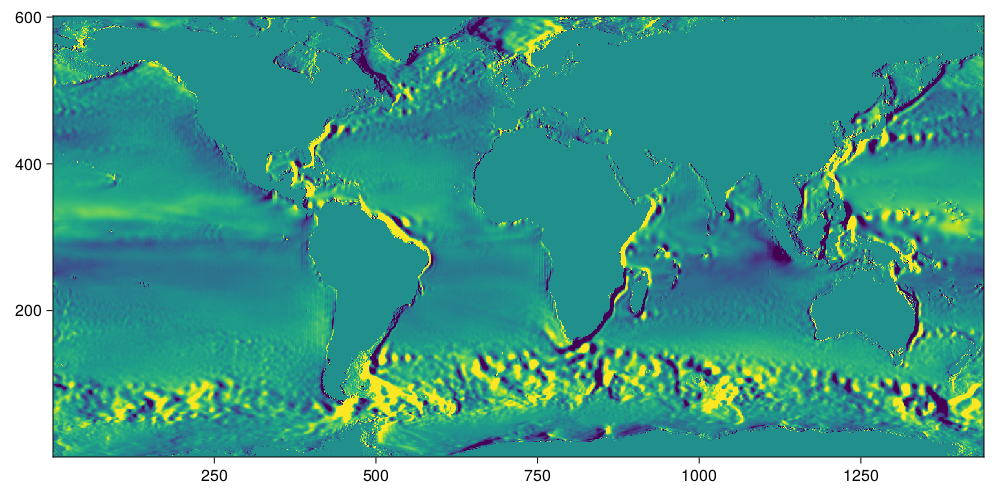

In [26]:
# Mean meridional velocity
v = Vm[:, :, 1]

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, v, colorrange = (-0.1, 0.1), colormap = :viridis)
current_figure()

### Oceananigans' `Field` type

Oceananigans represents variables discretized onto a particular grid with a `Field` type. <br> 
Fields are essentially containers that include the grid, the data allocated on the grid (the previously seen 3D arrays), <br>
and the associated boundary conditions.

We can define empty fields (i.e., empty containers associated with a grid) for our velocities and fill them with the velocity data we loaded

In [27]:
# Fields have a `location` in x, y and z. 
# They can be either poisitioned at the `Face` of the computational cell
# or at the `Center` of the cell

# By convention, U velocity is positioned at x `Face`s and `V` at y `Face`s
u_location = (Face, Center, Center)
v_location = (Center, Face, Center)

U = Field(u_location, grid)
V = Field(v_location, grid)

set_velocity_from_array!(U, Um)
set_velocity_from_array!(V, Vm)

1440×601×1 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
├── grid: 1440×600×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Nothing, north: Nothing, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 1446×607×7 OffsetArray(::Array{Float64, 3}, -2:1443, -2:604, -2:4) with eltype Float64 with indices -2:1443×-2:604×-2:4
    └── max=2.11723, min=-1.68651, mean=0.00533473

### Combining fields

Fields are handy because they can be combined through expressions. <br>
as an example, let us calculate the mean kinetic energy at the surface defined as

$$K = 0.5 * (U^2 + V^2)$$

In [28]:
K = Field(0.5 * (U^2 + V^2))
compute!(K)

1440×600×1 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
├── grid: 1440×600×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: ZeroFlux, north: ZeroFlux, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
├── operand: BinaryOperation at (Face, Center, Center)
├── status: time=0.0
└── data: 1446×606×7 OffsetArray(::Array{Float64, 3}, -2:1443, -2:603, -2:4) with eltype Float64 with indices -2:1443×-2:603×-2:4
    └── max=1.98573, min=0.0, mean=0.00737816

We can plot kinetic energy with `CairoMakie` (as has been done before), but only after extracting the data! <br>

To access the data associated with an Oceananigans field we use the function `interior`

In [29]:
k = interior(K)

# The data associated with a field is always three dimensional!
k

1440×600×1 view(::Array{Float64, 3}, 4:1443, 4:603, 4:4) with eltype Float64:
[:, :, 1] =
 0.0025052   0.000545485  0.000173222  …  1.24032e-5   1.23176e-5
 0.0028862   0.00168877   0.00130564      2.19016e-5   2.76373e-5
 0.00252467  0.00166898   0.00177873      2.10108e-5   3.19533e-5
 0.001878    0.000464617  0.00102316      2.45539e-5   2.54113e-5
 0.00181119  0.000222643  0.000526647     3.21952e-5   2.67016e-5
 0.00226474  0.000242008  0.000372989  …  8.14361e-5   5.50357e-5
 0.0024037   0.000133175  0.000103808     0.000122461  8.30114e-5
 0.0020807   0.000214499  0.000101433     0.00012972   9.25328e-5
 0.00195661  0.000484376  0.000315551     0.000150107  0.000108895
 0.00148305  0.000357141  0.000812631     0.00017314   0.00013151
 ⋮                                     ⋱               
 0.00290847  0.00109377   0.000707089     1.20452e-5   6.39648e-6
 0.00230514  0.000839348  0.000939637     1.15991e-5   6.19981e-6
 0.00200242  0.000741691  0.000991374     2.11009e-5   5.6000

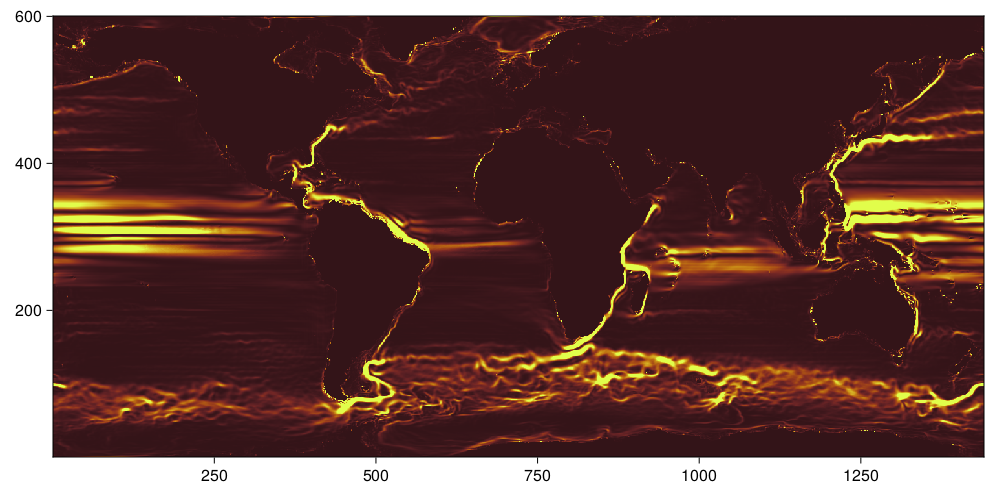

In [30]:
fig = Figure(resolution = (1000, 500))
ax = Axis(fig[1, 1])
heatmap!(ax, k[:, :, 1], colorrange = (0, 0.05), colormap = :solar)

current_figure()

### Computing derivatives

In the same way, we can compute derivatives. <br>
For example, let us calculate and plot the latitudinal derivative of the zonal velocity
$$S = \frac{\partial U}{\partial x}$$

Note that Julia supports Unicode. <br>
The differentiation operator in Oceananigans is defined with the $\partial$ symbol. <br>
To write it out in Julia, type `\partial` and then press the TAB key.

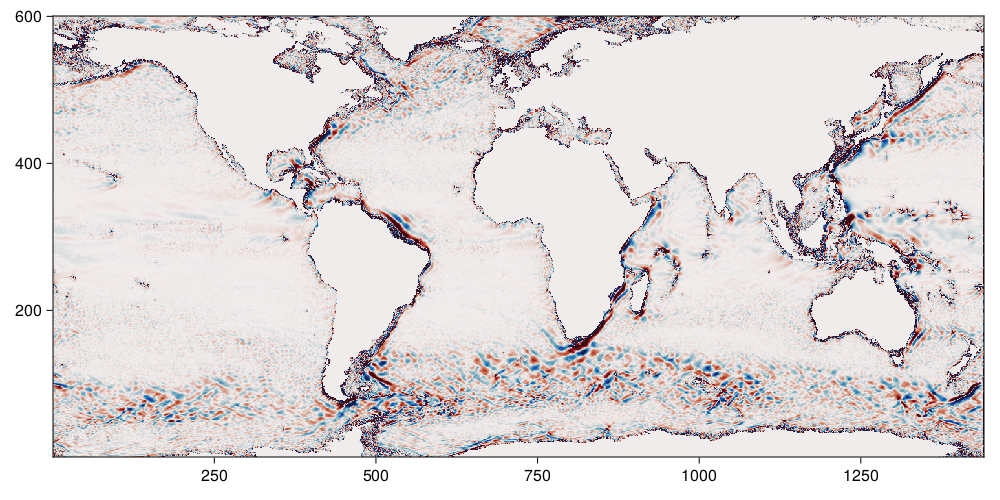

In [31]:
S = Field(∂x(U))
compute!(S)

s = interior(S)

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, s[:, :, 1], colorrange = (-2e-6, 2e-6), colormap = :balance)

current_figure()

## Exercise: interact with the velocity field

Define and plot a new field as a function of `U` and `V`.

As an example, could calculate vertical vorticity ($\zeta$) or horizontal divergence ($\delta$), where: 

$$\zeta = \frac{\partial V}{\partial x} - \frac{\partial U}{\partial y} \ , \ \ \ \ \text{and} \ \ \ \ \delta = \frac{\partial U}{\partial x} + \frac{\partial V}{\partial y}$$

#### Remember!
- the derivative operator in Oceananigans is constructed with \partial+TAB (followed by the direction: x or y).
- `heatmap!` plots 2D AbstractArrays.
- The `interior` function retrieves the data associated with a field.
- Fields (and associated data) are _always_ three-dimensional.

#### Tips
- Use the `typeof` and `size` function to confirm that the variable you want to plot is a 2D array (or matrix).
- Follow the example above for plotting and use `colorrange = (extrema(field))` and `colormap = :blues`.
- Do not forget to display the figure with `current_figure()` at the end of the cell!

In [15]:
## Write the new field here
## look at the examples above:

# - define the operation you want to calculate (ex: U + 0.5 * V)
# - wrap it around a Field constructor (field = Field(expression))
# - compute the field with compute!(field)
# - extract the data with data = interior(field)
# - display the data with heatmap!